## Setup and Utility

In [31]:
from abm import virtual_population
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# Plotting and analysis utility
def to_cdf(data):
    data_sorted = np.sort(data)
    n = len(data)
    return data_sorted, np.linspace(1, n, n)/n

## Task 1: load the parameter table from the dependencies

In [35]:
# Use pd.read_csv to load the included dependency for the parameter table solution

parameter_table = pd.read_csv('parameter_table_solution.csv')
display(parameter_table)

,parameter,unit,value,is_fit,prior,lower_bound,upper_bound
0,dummy0,1,0,True,loguniformprior,2,10
1,dummy1,1,0,True,loguniformprior,2,10


This is the same format as used for optimization earlier in the day. This defines a prior on your parameters.

## Task 2: build the table describing the clinical data you want to match
This part of the example uses empirical distributions. See below for how to use a multivariate normal distribution that includes a fit of covariance.

In [61]:
# The synthetic data for the toy illustration model has two outputs:
# "output0" and "output1", they are suffixed with their time,
# both at "0 days" --> common for reproducing baseline characteristics of a population

synthetic_clinical = pd.read_csv('clinical_empirical.csv')
synthetic_clinical.head()

,output0_0:d,output1_0:d
0,5.353005,5.405987
1,5.438402,5.382276
2,4.425038,4.635840
3,6.375106,5.082532
4,3.762521,3.979900


In [51]:
# Build an empirical distribution from the synthetic data
# - Use np.percentile(...)
# - Access a vector of clinical data using synthetic_clinical[ output column name ]
# - Choose percentiles from 0 to 100 by 10s to create 11 "bin edges" for each output

### Begin your edits

edges_output_0 = np.percentile(synthetic_clinical['output0_0:d'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
edges_output_1 = np.percentile(synthetic_clinical['output1_0:d'], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

### End your edits

probs = [0.1] * 10 # python syntax to make a 10 element list of 0.1 probabiliteies

# Simple code to build table; this could also be supplied as a CSV file dependency to reduce code.
histogram_table = pd.DataFrame(dict(
    target=['output0', 'output1'],
    distribution=['HistogramDistribution', 'HistogramDistribution'],
    distribution_unit = [1, 1],
    bin_edges=[
        list(edges_output_0),
        list(edges_output_1),
    ],
    bin_probabilities=[
        probs,
        probs,
    ],
    time= [0, 0], # time of observations
    time_unit = ['d', 'd'],
    smoothness=[0,0],
))

In [62]:
# Inspect the table defining the "histogram" or empirical distribution of the clinical data
display(histogram_table)

,target,distribution,distribution_unit,bin_edges,bin_probabilities,time,time_unit,smoothness
0,output0,HistogramDistribution,1,"[2.022595593299331, 3.5512370923705605, 3.9797...","[0.10000000000000002, 0.10000000000000002, 0.1...",0,d,0
1,output1,HistogramDistribution,1,"[2.0083723381635705, 3.6633687847723504, 3.960...","[0.10000000000000002, 0.10000000000000002, 0.1...",0,d,0


## Task 3: Run the virtual population with the provided defaults
We would explore alternative configurations and when to use them in a longer course. 

In [53]:
vpop = virtual_population(
    distributions=histogram_table,
    proposal_distributions=histogram_table,
    models='./fast_vpop_demo.model',
    parameters= parameter_table,
    proposal_method = "ClassifierSurrogate",
    proposal_options = {'sample_n': 5000, 'max_iters': 10, 'init_batch_size': 1000, 'max_batch_size': 1000},
    virtual_options = {'expected_n': 200},
    seed=15,
)

Total: 5379, Running: 0, Succeeded: 5034, Failed: 345

Total: 5033, Running: 0, Succeeded: 5033, Failed: 0

In [54]:
out = vpop.virtual_population_predictions()

Total: 197, Running: 0, Succeeded: 197, Failed: 0

## Plot and compare results

In [55]:
prior_samples = np.exp(np.random.uniform(np.log(2), np.log(10), size=10000))

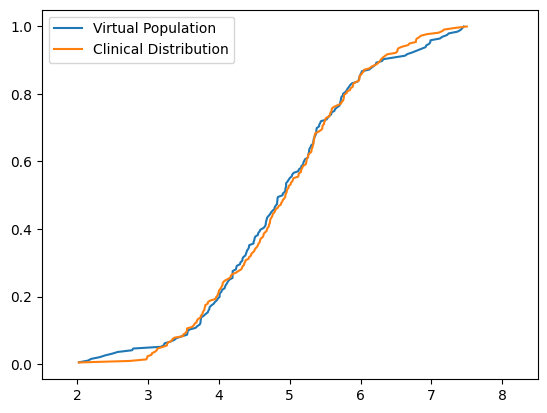

In [59]:
# Plot the cummulative distribution of the virtual popultion and the clinical population
x_prior, cdf_prior = to_cdf(prior_samples)
x_vpop, cdf_vpop = to_cdf(out['output0_0:d'])
x_clinical, cdf_clinical = to_cdf(synthetic_clinical['output0_0:d'])

plt.plot(x_vpop, cdf_vpop, label='Virtual Population')
plt.plot(x_clinical, cdf_clinical, label='Clinical Distribution')


#### Additional information for illustration

# plt.plot(x_prior, cdf_prior, label='Prior')
# for e in histogram_table.bin_edges[0]:
#     plt.axvline(e, linestyle='--', color='k')

plt.legend()
plt.xlim([1.5, 8.5])
plt.show()

## Alternative Proposal Using MVN
Many times, covarying observations are easier to model with multivariate normals. They are easier to interpet and computationally easier, but have less freedom than empirical distributions.

Robust multivariate empirical distributions are on our roadmap.

In [63]:
mvn_table = pd.DataFrame(dict(
    target=[['output0', 'output1']],
    distribution=['MultivariateNormalDistribution'],
    distribution_unit = [[1,1]],
    measurements=[[5, 5]],
    measurements_unit=[['1', '1']],
    covariance=[
        [[1, .9], [.9, 1]]
    ],
    time=[[time]*2],
    time_unit=[['d', 'd']]
))

display(mvn_table)

,target,distribution,distribution_unit,measurements,measurements_unit,covariance,time,time_unit
0,"[output0, output1]",MultivariateNormalDistribution,"[1, 1]","[5, 5]","[1, 1]","[[1, 0.9], [0.9, 1]]","[0, 0]","[d, d]"


In [12]:
vpop_mvn = virtual_population(
    distributions=mvn_table,
    proposal_distributions=histogram_table,
    models='./fast_vpop_demo.model',
    parameters= parameter_table,
    proposal_method = "ClassifierSurrogate",
    proposal_options = {'sample_n': 5000, 'max_iters': 10, 'init_batch_size': 1000, 'max_batch_size': 1000},
    virtual_options = {'expected_n': 200},
    seed=15,
)

Total: 0, Running: 0, Succeeded: 0, Failed: 0

Total: 0, Running: 0, Succeeded: 0, Failed: 0

In [13]:
out = vpop_mvn.virtual_population_predictions()

Total: 0, Running: 0, Succeeded: 0, Failed: 0

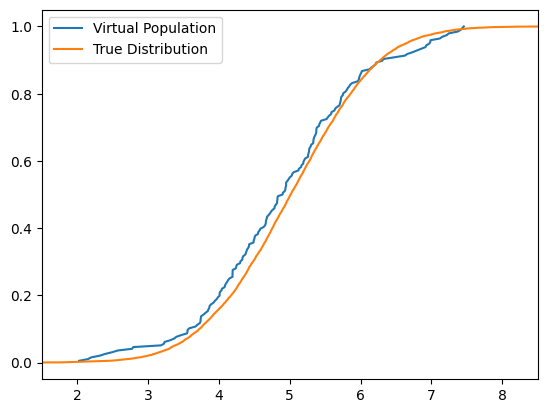

In [64]:
x_prior, cdf_prior = to_cdf(prior_samples)
x_vpop, cdf_vpop = to_cdf(out['output0_0:d'])
plt.plot(x_vpop, cdf_vpop, label='Virtual Population')

sample = np.random.multivariate_normal([5,5], [[1, .9], [.9, 1]], size=10000)
x_mvn, cdf_mvn = to_cdf(sample[:, 0])
plt.plot(x_mvn, cdf_mvn, label='True Distribution')

plt.legend()
plt.xlim([1.5, 8.5])
plt.show()